# Static Unconstrained Optimization with Neural Network

In this code I try to approximate the value function of a constrained optimization problem by means of Karush-Kuhn-Tucker condition. The idea that motivates the use of neural network to solve an optimization problem of this kind is related to the fact that many time we are interested in the value function and the optimal solution of a problem as a function of one or more parameter. Instead of solving repeatedly the same problem for each parameter here I propose a code that is able to solve once for a particular subset of the parameter space.

I use a problem with a closed form solution and I compare the true solution vs the approximated one

In [1]:
# Import section
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers.legacy import Adam
import matplotlib.pyplot as plt

from IPython.display import display, clear_output
import time

In [2]:
# Problem parameters
α_min = -5.
α_max = -1.

β_min = -5.
β_max = 5.

BATCH_SIZE = 8

In [3]:
def true_sol(α, β):
    return -β/(2*α)

## The problem

I want to solve the following problem:

$$
V(\alpha, \beta) = \max_{x} \left\{ \alpha\;x^2 + \beta\; x \right\}\\
$$

Provided that $\alpha < 0$ the function is globally concave therefore the optimal solution will be:
$$
x^*(\alpha, \beta) = -\frac{\beta}{2\alpha}
$$

Therefore the value function will be:
$$
V(\alpha, \beta) = -\frac{\beta}{2}\left(1 + \frac{\beta}{\alpha}\right)
$$

Suppose that you don't know the explicit solution and you want to approximate the parametrized solution $x^*(\alpha, \beta)$. We recognize that $x^* : \Alpha \times \Beta \rightarrow \mathbb{R}$ and this is the function we parametrize with a Neural Network. 

More specifically, the code below construct the approximated solution $\hat{x}^*(\alpha, \beta ; \theta)$ where $\theta$ are parameters of the neural network. 

In [4]:
# Convenient function to construct the neural network
def NN(nUnits = 128, nLayers = 3, act_fun = 'tanh', input_dim = 2, output_dim = 1, activation_out = 'linear', initGuess = 0):
    model = tf.keras.models.Sequential()
    
    # Add the input layer
    model.add(tf.keras.layers.Dense(nUnits, activation=act_fun, input_dim=input_dim))
    
    # Add the intermediate layers
    for layer in range(nLayers - 1):
        model.add(tf.keras.layers.Dense(nUnits, activation = act_fun))
    
    # Output layer
    model.add(tf.keras.layers.Dense(output_dim, activation=activation_out))
    return model

In [5]:
x_NN = NN()

def x(α, β):
    # Normalize the input vectors
    α = (α - α_min)/(α_max - α_min)*2.0 - 1.0
    β = (β - β_min)/(β_max - β_min)*2.0 - 1.0

    # Concatenate
    inp = tf.concat([α, β], axis=1)

    # Output the solution
    return x_NN(inp)

## Constructing an appropriate Loss Function

Since for the parameter space the problem is Concave, a sufficient condition for a maximum is that:
$$\frac{\partial f(x^*)}{\partial x} = 0$$

that is $$\frac{\partial f}{\partial x} = 2 \alpha \hat{x}^*(\alpha, \beta ; \theta) + \beta = 0$$

At this point we can construct a loss function based on that condition, that is:

$$\mathcal{L}(\alpha, \beta, \hat{x}^*; \theta) = || 2 \alpha \hat{x}^*(\alpha, \beta ; \theta) + \beta ||_2^2$$

And we know that this function at his minimum must be 0. So the algorithm works as follows:

1) Sample $(\alpha, \beta)$ from the parameter space
2) Guess a solution at $\hat{x}^*(\alpha, \beta ; \theta)$
3) Evaluate $\mathcal{L}(\alpha, \beta, \hat{x}^*; \theta)$
4) Improve the Loss with updating the gradient of the NN
5) Stop when max. iter is reached or error is below a threshold

In [6]:
def loss_function(n):
    
    # Sample the parameter space from uniform distribution

    α = np.linspace(α_min, α_max, 50).reshape(-1,1)
    β = np.linspace(β_min, β_min, 50).reshape(-1,1)

    # Guess the solution
    x_star = x(α, β)

    # Evaluate and return the loss function
    loss = 2*α*x_star + β
    
    return tf.reduce_mean(tf.square(loss)) 

In [7]:
Θ = x_NN.trainable_variables
optimizer = Adam(learning_rate=0.003)

@tf.function
def training_step():
    with tf.GradientTape(persistent=True) as tape:
        # Compute the loss function
        L = loss_function(BATCH_SIZE)
        
    # Compute the gradient of the total loss function with respect to the network parameters    
    grad = tape.gradient(L, Θ)

    # Update parameters
    optimizer.apply_gradients(zip(grad, Θ))
    
    return L

In [8]:
def train(epochs):
    # To store the loss in order to plot
    total_losses = []
    
    # Take track of the starting time
    start = time.time()
    
    for i in range(0,epochs):
        loss = training_step()
        
        # Append the loss function
        total_losses.append(loss.numpy())
        
        # Take track of the time
        now = time.time()
        
        print(f"""
        time elapsed: {now - start}
        epoch : {i+1}
        loss : {loss}
        """)
    return total_losses

In [9]:
total_err = train(50000)


        time elapsed: 0.14430689811706543
        epoch : 1
        loss : 28.364551544189453
        

        time elapsed: 0.1451127529144287
        epoch : 2
        loss : 11.98431396484375
        

        time elapsed: 0.1455979347229004
        epoch : 3
        loss : 11.870439529418945
        

        time elapsed: 0.14619183540344238
        epoch : 4
        loss : 1.5412760972976685
        

        time elapsed: 0.14665889739990234
        epoch : 5
        loss : 3.443251848220825
        

        time elapsed: 0.14718985557556152
        epoch : 6
        loss : 7.6789727210998535
        

        time elapsed: 0.14765691757202148
        epoch : 7
        loss : 5.463351249694824
        

        time elapsed: 0.14813995361328125
        epoch : 8
        loss : 1.8104920387268066
        

        time elapsed: 0.14858293533325195
        epoch : 9
        loss : 0.894029438495636
        

        time elapsed: 0.14907169342041016
        epoch : 10
        

# Plots

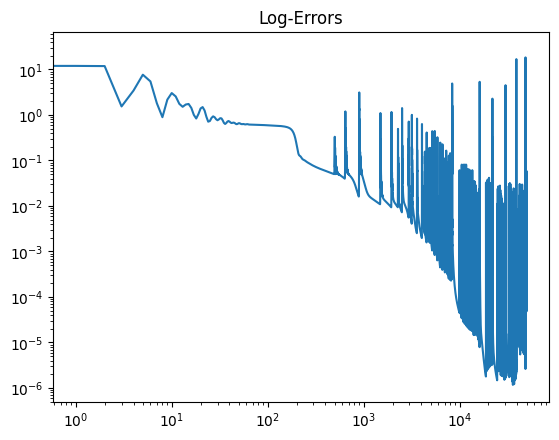

In [10]:
plt.figure()
plt.title('Log-Errors')
plt.xscale('log')
plt.yscale('log')
plt.plot(total_err)
plt.show()

In [11]:
A = np.linspace(α_min, α_max, 50).reshape(-1,1)
B = np.linspace(β_min, β_min, 50).reshape(-1,1)

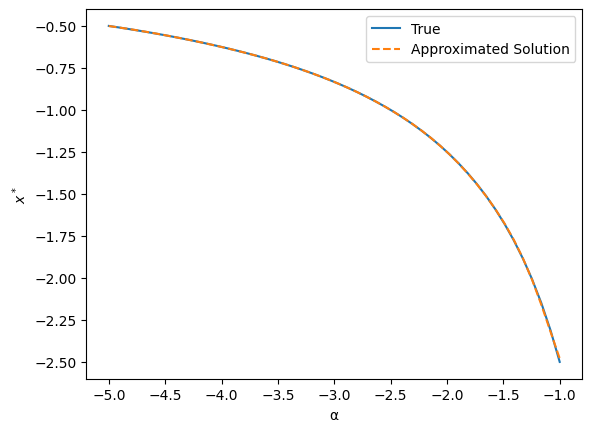

In [17]:
plt.figure()
plt.plot(A, true_sol(A, -5.),label='True')
plt.plot(A, x(A, B),linestyle="--",label='Approximated Solution')
plt.xlabel("α")
plt.ylabel("$x^*$")
plt.legend()